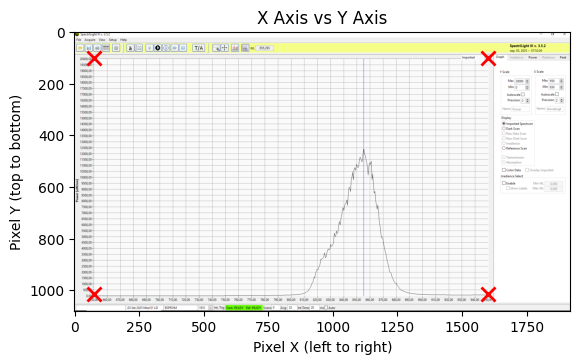

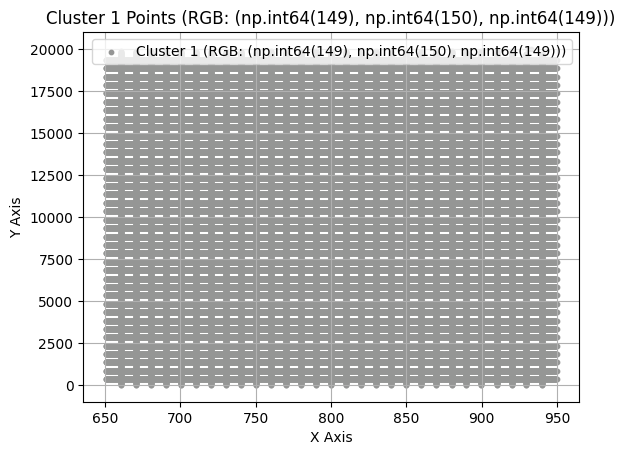

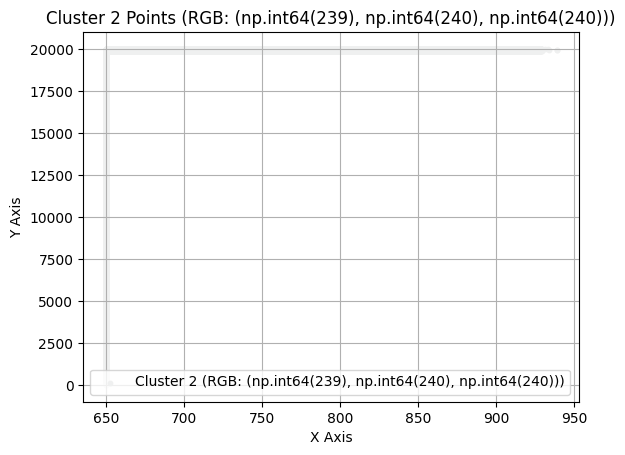

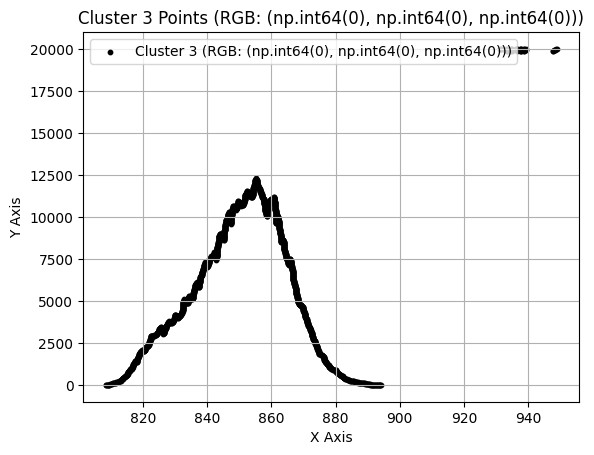

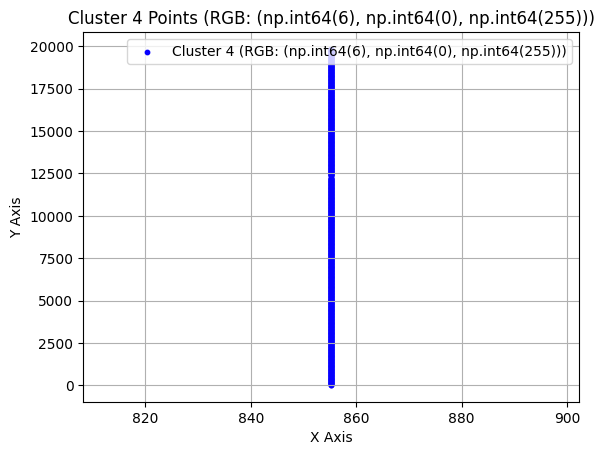

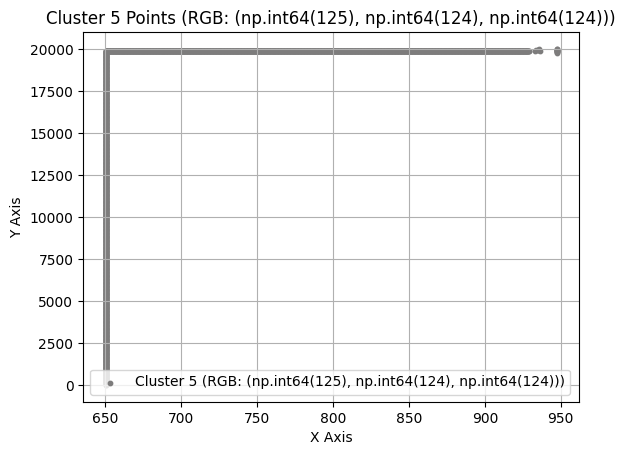

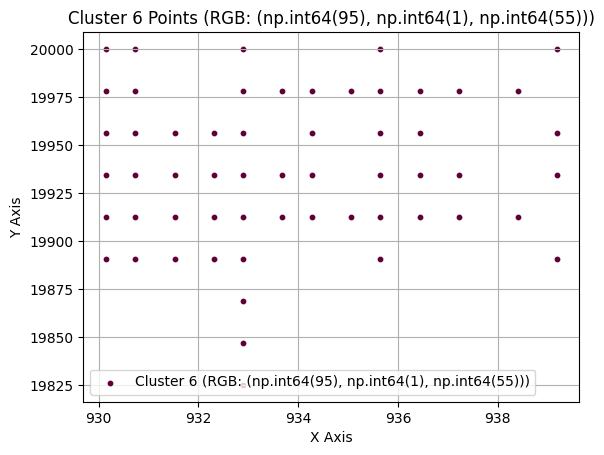

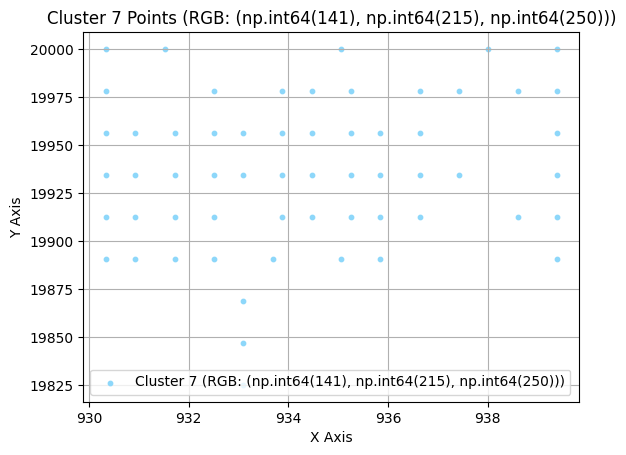

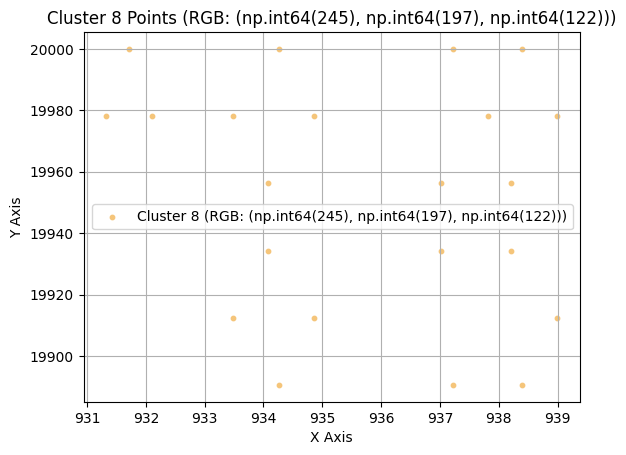

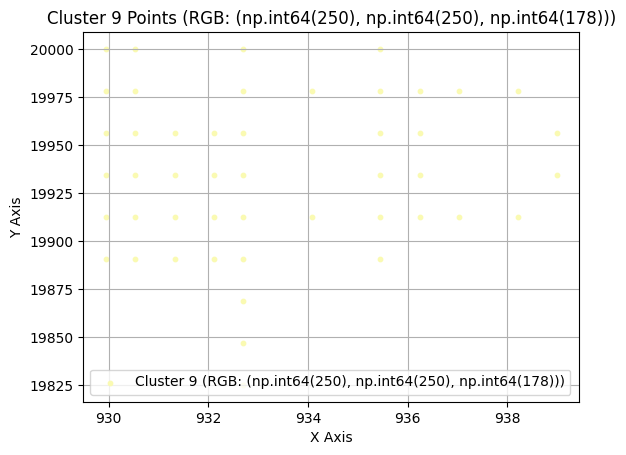

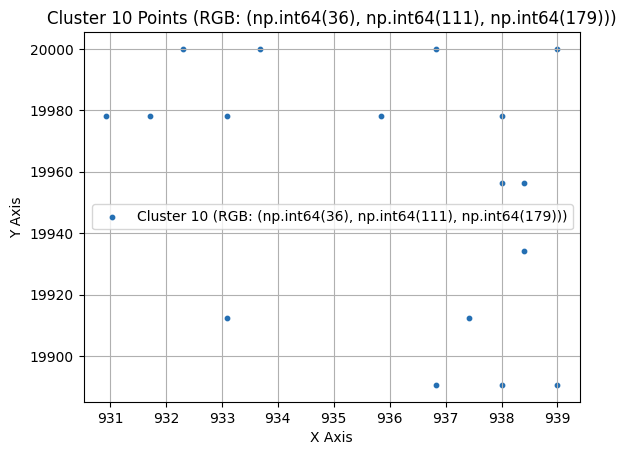

Color (np.int64(149), np.int64(150), np.int64(149)): 84464 points
Color (np.int64(239), np.int64(240), np.int64(240)): 9433 points
Color (np.int64(0), np.int64(0), np.int64(0)): 1791 points
Color (np.int64(6), np.int64(0), np.int64(255)): 902 points
Color (np.int64(125), np.int64(124), np.int64(124)): 2343 points
Color (np.int64(95), np.int64(1), np.int64(55)): 57 points
Color (np.int64(141), np.int64(215), np.int64(250)): 59 points
Color (np.int64(245), np.int64(197), np.int64(122)): 22 points
Color (np.int64(250), np.int64(250), np.int64(178)): 47 points
Color (np.int64(36), np.int64(111), np.int64(179)): 17 points


In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import csv

def reverse_engineer_plot(image_path, x_label, y_label, x_range, y_range, origin, graph_size, file_title="spectral_power_vs_wavelength"):
    """
    Reverse engineer a plot from an image, extracting colored points and clustering them.
    
    Parameters:
    - image_path: Path to the input image
    - x_label, y_label: Labels for x and y axes
    - x_range, y_range: Tuples of (min, max) for real-world coordinates
    - origin: (x, y) pixel coordinates of the graph's origin (top-left corner)
    - graph_size: (width, height) in pixels of the graph area
    - file_title: Base title for the output file (default: "spectral_power_vs_wavelength")
    
    Returns:
    - Dictionary of clusters: {color: [(x, y), ...]}
    
    Note: Pixel coordinates are counted from top-left (x: left to right, y: top to bottom).
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Validate image dimensions
    img_height, img_width = img.shape[:2]
    ox, oy = origin
    width, height = graph_size
    
    if ox < 0 or oy < 0 or ox + width > img_width or oy + height > img_height:
        max_width = img_width - ox
        max_height = img_height - oy
        raise ValueError(
            f"Graph area out of bounds: origin=({ox}, {oy}), size=({width}, {height}), "
            f"image size=({img_width}, {img_height}). "
            f"Max width={max_width}, max height={max_height}."
        )
    
    # Extract graph area
    graph_area = img[oy:oy+height, ox:ox+width]
    
    # Plot corners with red 'x' markers
    plt.imshow(img)
    corners = [(ox, oy), (ox+width, oy), (ox, oy+height), (ox+width, oy+height)]
    for corner in corners:
        plt.plot(corner[0], corner[1], 'rx', markersize=10, markeredgewidth=2)
    plt.title(f"{x_label} vs {y_label}")
    plt.xlabel("Pixel X (left to right)")
    plt.ylabel("Pixel Y (top to bottom)")
    plt.show()
    
    # Map pixel coordinates to real-world coordinates
    x_min, x_max = x_range
    y_min, y_max = y_range
    x_scale = (x_max - x_min) / width
    y_scale = (y_max - y_min) / height
    
    # Extract non-white pixels
    non_white_pixels = []
    colors = []
    white_threshold = 240  # Threshold for considering a pixel "white"
    
    for y in range(height):
        for x in range(width):
            pixel = graph_area[y, x]
            if not all(pixel > white_threshold):  # Not white
                real_x = x_min + x * x_scale
                real_y = y_max - y * y_scale  # Invert y for real-world
                non_white_pixels.append((real_x, real_y))
                colors.append(pixel)
    
    if not non_white_pixels:
        return {}
    
    # Convert to numpy arrays
    non_white_pixels = np.array(non_white_pixels)
    colors = np.array(colors)
    
    # Cluster colors with tolerance
    n_clusters = min(len(np.unique(colors, axis=0)), 10)  # Limit clusters
    if n_clusters == 0:
        return {}
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    color_labels = kmeans.fit_predict(colors)
    
    # Group points by color cluster
    clusters = {}
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for label in range(n_clusters):
        mask = color_labels == label
        cluster_points = non_white_pixels[mask]
        cluster_color = np.mean(colors[mask], axis=0).astype(int)
        color_key = tuple(cluster_color)
        
        clusters[color_key] = cluster_points.tolist()
        
        # Save to file based on color
        output_dir = Path("clusters")
        output_dir.mkdir(exist_ok=True)
        if all(c < 10 for c in cluster_color):  # Consider color as black if all values < 10
            output_file = output_dir / f"{file_title}{timestamp}.csv"
            with open(output_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([x_label, y_label])  # Write headers
                writer.writerows(cluster_points)  # Write points
        else:
            output_file = output_dir / f"cluster_{label+1}_{timestamp}.txt"
            with open(output_file, 'w') as f:
                f.write(f"Cluster {label+1} - Color (RGB): {color_key}\n")
                f.write(f"Points ({x_label}, {y_label}):\n")
                for point in cluster_points:
                    f.write(f"{point[0]:.4f}, {point[1]:.4f}\n")
    
    # Plot each cluster in a separate plot
    for i, (color, points) in enumerate(clusters.items()):
        plt.figure()
        x_coords, y_coords = zip(*points)
        # Normalize RGB values to [0, 1] range
        normalized_color = tuple(c / 255.0 for c in color)
        plt.scatter(x_coords, y_coords, c=[normalized_color], label=f'Cluster {i+1} (RGB: {color})', s=10)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f"Cluster {i+1} Points (RGB: {color})")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Print cluster info
    for color, points in clusters.items():
        print(f"Color {color}: {len(points)} points")
    
    return clusters

# Example usage
if __name__ == "__main__":
    # Example parameters (replace with actual values)
    image_path = r"G:\MARIN\espectro_sonda.png"
    x_label = "X Axis"
    y_label = "Y Axis"
    x_range = (650, 950)  # Real-world x range
    y_range = (0, 20000)  # Real-world y range
    origin = (75, 100)  # Pixel coordinates of origin
    graph_size = (1601-75, 1020-106)  # Width, height in pixels
    file_title = "spectral_power_vs_wavelength"  # Example custom title
    try:
        clusters = reverse_engineer_plot(
            image_path, x_label, y_label, x_range, y_range, origin, graph_size, file_title
        )
    except ValueError as e:
        print(f"Error: {e}")